# Distributed Bragg reflector and cavity

A [distributed Bragg reflector](https://en.wikipedia.org/wiki/Distributed_Bragg_reflector) (DBR) is a multilayer structure consisting of alternating layers of high refractive index and low refractive index. When the thickness of each layer is close to a quarter of the medium wavelength, nearly perfect reflection occurs due to constructive interference of the reflected waves at each layer. DBR is commonly used at optical and UV wavelengths due to the fact that metallic reflectors have a high loss at high frequencies. Besides free space optics, similar concepts have also been applied to integrated photonics and fiber optics. Furthermore, high-Q cavities based on DBR structures are widely popular in lasers, filters, and sensors.

Although Tidy3D uses highly optimized algorithms and hardware designed to perform large 3D simulations at ease, the computational efficiency can be improved exponentially if we can reduce the dimension of the model. The DBR structure has translational symmetry along the two in-plane directions. Thus, simulating a DBR is effectively a 1D problem. 

<img src="img/dbr_schematic.png" width=600 alt="Schematic of the DBR and cavity">

For a relevant example, please see the [waveguide bragg gratings notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/BraggGratings/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web


## Simulating the Stopband of a DBR

### Simulation Setup 

The most common DBR is made of alternating layers of titanium dioxide ($TiO_2$) and silica ($SiO_2$). The target stopband of the DBR is around 630 nm. 

In [2]:
lda0 = 0.63  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
freqs = freq0 * np.linspace(0.5, 1.5, 1001)  # frequency range of interest


In [3]:
n_tio2 = 2.5  # refractive index of TiO2
n_sio2 = 1.5  # refractive index of SiO2
n_s = 1.5  # refractive index of the substrate material. It's set to SiO2 in this case
inf_eff = 10  # effective infinity in this model


The bandwidth of the stopband is given by 

$$
\frac{\Delta f}{f_0} = \frac{4}{\pi} arcsin(\frac{n_1-n_2}{n_1+n_2}),
$$

where $f_0$ is the central frequency, $n_1$ is the refractive index of the high index material, and $n_2$ is the refractive index of the low index material. We use the above equation to estimate the bandwidth of the DBR.

In [4]:
df = 4 * np.arcsin((n_tio2 - n_sio2) / (n_tio2 + n_sio2)) / np.pi
print(f"The normalized bandwidth of the reflection band is {df:1.2f}")


The normalized bandwidth of the reflection band is 0.32


Next, we construct a function that builds the DBR layers given four parameters: the refractive indices of the materials, the number of layer pairs, and the starting position of the lowest layer. This function will be handy for constructing the DBR as well as the cavity device in the next section. 

In [5]:
def build_layers(n_1, n_2, N, z_0):
    # n_1 and n_2 are the refractive indices of the two materials
    # N is the number of repeated pairs of low/high refractive index material
    # z_0 is the z coordinate of the lowest layer

    material_1 = td.Medium(permittivity=n_1**2)  # define the first material
    material_2 = td.Medium(permittivity=n_2**2)  # define the second material
    t_1 = lda0 / (4 * n_1)  # thickness of the first material
    t_2 = lda0 / (4 * n_2)  # thicness of the second material
    layers = []  # holder for all the layers

    # building layers alternatively
    for i in range(2 * N):
        if i % 2 == 0:
            layers.append(
                td.Structure(
                    geometry=td.Box.from_bounds(
                        rmin=(-inf_eff, -inf_eff, z_0),
                        rmax=(inf_eff, inf_eff, z_0 + t_1),
                    ),
                    medium=material_1,
                )
            )
            z_0 = z_0 + t_1
        else:
            layers.append(
                td.Structure(
                    geometry=td.Box.from_bounds(
                        rmin=(-inf_eff, -inf_eff, z_0),
                        rmax=(inf_eff, inf_eff, z_0 + t_2),
                    ),
                    medium=material_2,
                )
            )
            z_0 = z_0 + t_2

    return layers


We plan to perform a parameter sweep of $N$, the number of layer pairs. In order to do so, we define another function that takes $N$ as an argument and builds the simulation including structures, source, monitor, and so on.

In [6]:
def make_DBR(N):

    # build the DBR layers using the previously defined function
    DBR = build_layers(n_tio2, n_sio2, N, 0)

    thickness = N * (
        lda0 / (4 * n_tio2) + lda0 / (4 * n_sio2)
    )  # total thickness of the DBR layers

    # build the substrate structure
    sub = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)
        ),
        medium=td.Medium(permittivity=n_s**2),
    )

    # the entire DBR structure includes the layers and the substrate
    DBR.append(sub)

    # create a plane wave excitation source
    fwidth = 0.5 * freq0  # width of the frequency distribution
    plane_wave = td.PlaneWave(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        size=(td.inf, td.inf, 0),
        center=(0, 0, thickness + lda0 / 4),
        direction="-",
        pol_angle=0,
    )

    # create a flux monitor to measure the reflectance
    flux_monitor = td.FluxMonitor(
        center=(0, 0, thickness + lda0 / 2),
        size=(td.inf, td.inf, 0),
        freqs=freqs,
        name="R",
    )

    Lz = thickness + 2 * lda0  # simulation domain size in z direction
    run_time = 100 / fwidth  # simulation run time

    sim = td.Simulation(
        size=(0, 0, Lz),  # simulation domain sizes in x and y directions are set to 0
        center=(0, 0, thickness / 2),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=lda0),
        structures=DBR,
        sources=[plane_wave],
        monitors=[flux_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
        ),  # pml is applied in the z direction
        shutoff=1e-7,
    )  # early shutoff level is decreased to 1e-7 to increase the simulation accuracy
    return sim


To visualize the relationship between reflectance and the number of repeated pairs, we perform a parameter sweep. N is swept from 2 to 10 in a total of 5 simulations.

In [7]:
Ns = np.array([2, 3, 4, 5, 10])  # collection of N for the parameter sweep
sims = {
    f"N={N:.2f}": make_DBR(N) for N in Ns
}  # construct simulations for each N from Ns


Submit the batch to the server. 

In [8]:
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")


Output()

12:18:11 UTC Started working on Batch containing 5 tasks.

12:18:15 UTC Maximum FlexCredit cost: 0.125 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

12:18:28 UTC Batch complete.

Output()

### Result Visualization 

Once the batch of simulations is complete, we can plot the reflectance spectra.

Analytically, the reflectance at the central frequency is given by

$$
R = [\frac{n_0(n_1)^{2N}-n_s(n_2)^{2N}}{n_0(n_1)^{2N}+n_s(n_2)^{2N}}]^2,
$$

where $n_0=1$ is the refractive index of the superstrate, $n_s=n_{SiO_2}$ is the refractive index of the substrate. We will use this analytical solution to validate the accuracy of our simulations.

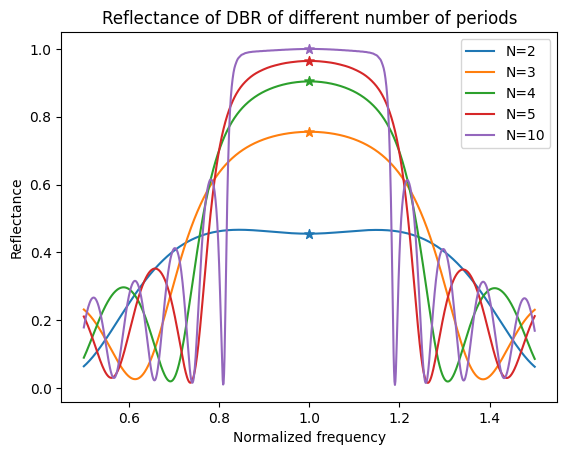

In [9]:
for i, N in enumerate(Ns):
    sim_data = batch_results[f"N={N:.2f}"]
    R = sim_data["R"].flux  # extract reflectance data from the flux monitor
    plt.plot(freqs / freq0, R, label=f"N={N}")  # plot reflectance spectrum

    # plot the analytically calculated reflectance at the central frequency with a star marker
    plt.scatter(
        1,
        (
            ((n_tio2) ** (2 * N) - (n_sio2) ** (2 * N + 1))
            / ((n_tio2) ** (2 * N) + (n_sio2) ** (2 * N + 1))
        )
        ** 2,
        marker="*",
        s=50,
    )

plt.title("Reflectance of DBR of different number of periods")
plt.xlabel("Normalized frequency")
plt.ylabel("Reflectance")
plt.legend()
plt.show()


As the number of pairs increases, the reflectance at the stopband increases to unity. The width of the stopband agrees with the analytical expression discussed above. The analytical solution of the reflectance at the central frequency (stars) also agrees well with Tidy3D simulation results.

## Modeling a High-Q DBR Microcavity

Similar to a defect in a photonic crystal, an optical microcavity is formed when one layer of a DBR has an anomalous thickness. For example, if a high index layer in the middle of a DBR has a thickness of half a material wavelength instead of the usual quarter material wavelength, the DBR will show greatly suppressed reflection at the central frequency. The quality factor of this cavity mode can be very high if the total number of layers is large. DBR-based microcavities are widely used in lasers, filters, and sensing applications. 

To obtain the reflectance spectrum of a high-Q DBR cavity, a long simulation run time is required since we need to run the time stepping until the energy in the simulation domain dissipates. Fortunately, for 1D or 2D simulations, this is still an easy task. 

On the other hand, for a large 3D cavity with a very high Q value, this kind of simulation can become computationally impractical. In this case, the [ResonanceFinder](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html) plugin of Tidy3D is a handy tool. It can be used to extract the resonance frequencies and Q values without running the time stepping until the resonance modes fully decay, as demonstrated in the [photonic crystal cavity example](https://www.flexcompute.com/tidy3d/examples/notebooks/OptimizedL3/).

### Simulation Setup 

To resolve the cavity resonance in the spectrum, we narrow the frequency range a bit compared to the previous simulations.

In [10]:
lda0 = 0.63  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
freqs = freq0 * np.linspace(
    0.9, 1.1, 1001
)  # frequency range of interest. The range is narrowed compared to previous simulations


To create a DBR cavity, we will use the previously defined `build_layers` function twice to construct the regular DBRs on the top and bottom of the cavity. Then a single layer of $TiO_2$ with thickness $\lambda_0/2n_{TiO_2}$ is added between them. 

/local_data_extra/flexcompute_ci/actions-runner/_work/tidy3d-core/tidy3d-core/tidy3d_frontend/tidy3d/components/scene.py:496: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(hlim)


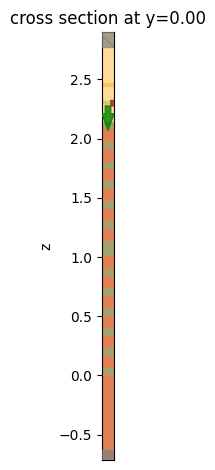

In [11]:
N_bottom = 6  # number of layer pairs for the bottom DBR
thickness_bottom = N_bottom * (
    lda0 / (4 * n_tio2) + lda0 / (4 * n_sio2)
)  # thickness of the bottom DBR
bottom_DBR = build_layers(n_tio2, n_sio2, N_bottom, 0)  # construct the bottom DBR

thickness_cavity = lda0 / (2 * n_tio2)  # thickness of the cavity layer
# construct the cavity layer
cavity = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, thickness_bottom),
        rmax=(inf_eff, inf_eff, thickness_bottom + thickness_cavity),
    ),
    medium=td.Medium(permittivity=n_tio2**2),
)

N_top = 6  # number of layer pairs for the top DBR
# construct the bottom DBR
top_DBR = build_layers(n_sio2, n_tio2, N_top, thickness_bottom + thickness_cavity)
thickness_top = N_top = N_bottom * (
    lda0 / (4 * n_tio2) + lda0 / (4 * n_sio2)
)  # thickness of the bottom DBR

# construct the substrate
sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)
    ),
    medium=td.Medium(permittivity=n_s**2),
)

# combining the top DBR, the bottom DBR, the cavity layer, and the substrate
DBR_cavity = bottom_DBR + top_DBR
DBR_cavity.append(cavity)
DBR_cavity.append(sub)

thickness = (
    thickness_bottom + thickness_cavity + thickness_top
)  # total thickness of the device

fwidth = 0.1 * freq0  # width of the frequency range

# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    center=(0, 0, thickness + lda0 / 4),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to measure reflectance
flux_monitor = td.FluxMonitor(
    center=(0, 0, thickness + lda0 / 2), size=(td.inf, td.inf, 0), freqs=freqs, name="R"
)

# add a field monitor to measure the field distribution
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), freqs=freqs, name="field"
)

# simulation domain size in z direction
Lz = thickness + 2 * lda0

# run time needs to be sufficiently long to ensure the field decays away in the end
run_time = 500 / fwidth

sim = td.Simulation(
    size=(0, 0, Lz),
    center=(0, 0, thickness / 2),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=60, wavelength=lda0),
    structures=DBR_cavity,
    sources=[plane_wave],
    monitors=[flux_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ),
    shutoff=1e-7,
)  # early shutoff level is decreased to 1e-7 to increase the simulation accuracy

# visulize the simulation setup
ax = sim.plot(y=0)
ax.get_xaxis().set_visible(False)


Submit the simulation job to the server.

In [12]:
sim_data = web.run(
    sim, task_name="dbr_cavity", path="data/simulation.hdf5", verbose=True
)


12:18:33 UTC Created task 'dbr_cavity' with task_id                             
             'fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=354795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=592970;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\taskId]8;;\]8;id=354795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\=]8;;\]8;id=382431;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\fdve]8;;\]8;id=354795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\-8fb5f51f-20f]8;;\
             ]8;id=354795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\e-4d64-a92b-335e6bb1c34e']8;;\.

Output()

12:18:35 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:18:39 UTC status = preprocess

12:18:41 UTC Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:19:50 UTC early shutoff detected at 64%, exiting.

             status = postprocess

Output()

12:19:52 UTC status = success

             View simulation result at                                          
             ]8;id=38953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=128207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\taskId]8;;\]8;id=38953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\=]8;;\]8;id=708835;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\fdve]8;;\]8;id=38953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\-8fb5f51f-20f]8;;\
             ]8;id=38953;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8fb5f51f-20fe-4d64-a92b-335e6bb1c34e\e-4d64-a92b-335e6bb1c34e']8;;\.

Output()

12:20:00 UTC loading simulation from data/simulation.hdf5

### Result Visualization 

Once the simulation is complete, we can plot the reflectance spectra. A sharp dip at the central frequency due to the cavity resonance mode is observed, in agreement with our expectation.

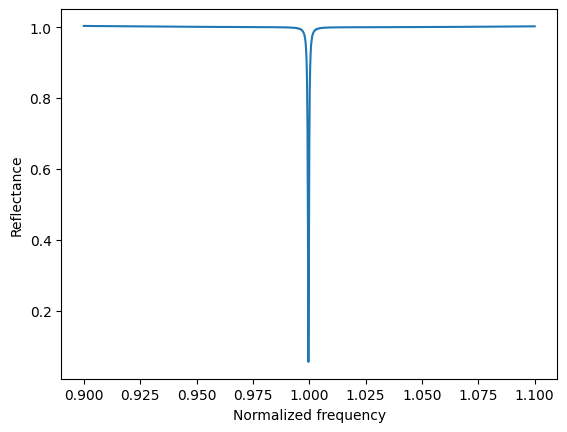

In [13]:
R = sim_data["R"].flux  # extracting reflection data from the flux monitor
plt.plot(freqs / freq0, R)
plt.xlabel("Normalized frequency")
plt.ylabel("Reflectance")
plt.show()


Finally, we visualize the frequency domain field distribution. Since the simulation is in 1D, we can not plot the field as a 2D false color image. Instead, we can plot it as a curve. The incident plane wave is polarized in the x direction, so we will look at the x component of the field. 

At the resonance frequency, the field distribution shows a strong localization at the cavity. On the contrary, when the frequency is slightly off-resonance, the field is exponentially decaying, leading to strong reflection. 

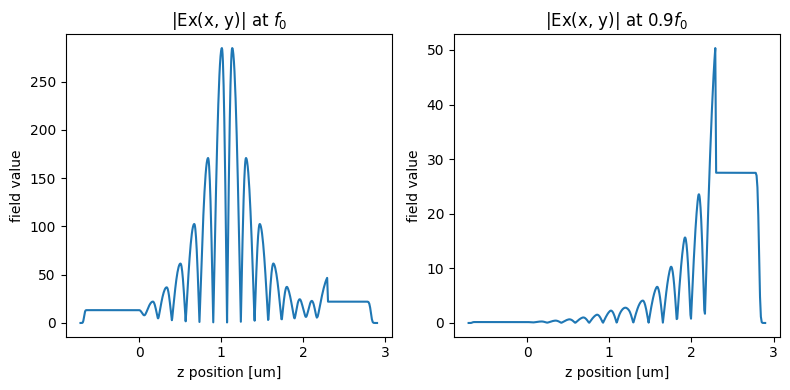

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))

# plot the field distribution at the resonance frequency
np.squeeze(sim_data["field"].Ex.sel(f=freq0)).abs.plot(ax=ax1)
ax1.set_title("|Ex(x, y)| at $f_0$")

# plot the field distribution at the off-resonance frequency
np.squeeze(sim_data["field"].Ex.sel(f=0.9 * freq0)).abs.plot(ax=ax2)
ax2.set_title("|Ex(x, y)| at $0.9f_0$")
plt.show()
